# Task 1: Design an In-Silico Perturbation Workflow

## Objective
Develop a flexible, scalable workflow to simulate gene knock-up (upregulation) and knock-down (downregulation) experiments in single-cell RNA-seq data.

## Approach
1. Load and explore the ALS single-cell dataset
2. Design perturbation functions with biological constraints
3. Implement validation and quality control
4. Create visualization tools for perturbation effects
5. Demonstrate scalability with multiple genes

## Notebook Run Guide

**Purpose:** Operational reference for constructing the perturbation workflow that feeds downstream tasks.

**Key dependencies:** scanpy, nndata, 
umpy, pandas, helper modules from nalysis.py, perturbation.py, and data_utils.py.

**Required data:** localtools/counts_combined_filtered_BA4_sALS_PN.h5ad (baseline expression matrix used for all demonstrations).

**Execution steps:**
1. Adjust the configuration cells at the top (sampling flags, output paths) if you need a quicker dry run.
2. Execute notebook cells sequentially; perturbation helper functions must be defined before the demonstration sections.
3. Review validation plots in Sections 6 and 7 before exporting perturbed AnnData files.

**Outputs generated:**
- Example AnnData object perturbed_expression.h5ad saved to 	hird attempt/.
- Quality-control figures written to 	hird attempt/outputs/images/ with the 	ask1_ prefix.

**Validation tips:**
- Confirm perturbed_gene, perturbation_type, and 
old_change appear in data.obs for each perturbation.
- Inspect console logs for sparse matrix conversion warnings; rerun cells if memory usage spikes or outputs look truncated.


In [8]:
%pip install numpy pandas scikit-learn matplotlib seaborn
%pip install helical
# %pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu126

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# This seems to fix some issues with helicals integration with torch and CUDA versions.@ Newer GPU's need CUDA 13.0, but helical is built against CUDA 12.6.
# %pip install --upgrade torch --index-url https://download.pytorch.org/whl/cu130

In [10]:
# Import required libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set plotting parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style('whitegrid')

## 1. Load and Explore Dataset

In [11]:
# Load the ALS dataset
DATA_PATH = '../localtools/counts_combined_filtered_BA4_sALS_PN.h5ad'  # Update with your path
adata = sc.read_h5ad(DATA_PATH)

print(f"Dataset shape: {adata.shape}")
print(f"\nCondition distribution:")
print(adata.obs['Condition'].value_counts())
print(f"\nCell type distribution (top 10):")
print(adata.obs['CellType'].value_counts().head(10))

Dataset shape: (112014, 22832)

Condition distribution:
Condition
ALS    66960
PN     45054
Name: count, dtype: int64

Cell type distribution (top 10):
CellType
Oligo     19043
Astro     13178
L2_L3     11871
OPC        9416
L3_L5      9331
L4_L6      7512
L5_L6      6608
5HT3aR     6034
PV         5595
L6         4848
Name: count, dtype: int64


In [12]:
# Examine gene expression statistics
print("Gene expression summary:")
print(f"Mean counts per cell: {adata.X.sum(axis=1).mean():.2f}")
print(f"Mean genes expressed per cell: {(adata.X > 0).sum(axis=1).mean():.2f}")
print(f"Mean expression per gene: {adata.X.sum(axis=0).mean():.2f}")

Gene expression summary:
Mean counts per cell: 11771.92
Mean genes expressed per cell: 3601.49
Mean expression per gene: 57753.15


## 2. Design Perturbation Workflow

### Key Design Principles:
1. **Biological Realism**: Perturbations should mimic realistic expression changes
2. **Flexibility**: Support single or multiple gene perturbations
3. **Scalability**: Handle large numbers of cells efficiently
4. **Reproducibility**: Maintain original data integrity with copy-on-write
5. **Validation**: Include quality control checks

In [13]:
class GenePerturber:
    """
    A class for performing in-silico gene perturbations on single-cell RNA-seq data.
    
    This class provides methods to simulate gene knock-down (downregulation) and 
    knock-up (upregulation) experiments while maintaining biological realism.
    """
    
    def __init__(self, adata, copy=True):
        """
        Initialize the GenePerturber.
        
        Parameters:
        -----------
        adata : AnnData
            The annotated data matrix
        copy : bool
            Whether to work on a copy of the data (default: True)
        """
        self.adata = adata.copy() if copy else adata
        self.perturbations_log = []
        
    def validate_genes(self, genes: Union[str, List[str]]) -> List[str]:
        """
        Validate that genes exist in the dataset.
        
        Parameters:
        -----------
        genes : str or list of str
            Gene name(s) to validate
            
        Returns:
        --------
        list : Valid gene names
        """
        if isinstance(genes, str):
            genes = [genes]
        
        valid_genes = []
        for gene in genes:
            if gene in self.adata.var_names:
                valid_genes.append(gene)
            else:
                print(f"Warning: Gene '{gene}' not found in dataset. Skipping.")
        
        return valid_genes
    
    def knock_down(self, 
                   genes: Union[str, List[str]], 
                   factor: float = 0.1,
                   cell_indices: np.ndarray = None,
                   complete_knockout: bool = False) -> 'GenePerturber':
        """
        Simulate gene knock-down (downregulation).
        
        Parameters:
        -----------
        genes : str or list of str
            Gene(s) to knock down
        factor : float
            Multiplicative factor for downregulation (default: 0.1 = 90% reduction)
        cell_indices : np.ndarray
            Specific cells to perturb (default: None = all cells)
        complete_knockout : bool
            If True, set expression to 0 (default: False)
            
        Returns:
        --------
        self : GenePerturber
        """
        genes = self.validate_genes(genes)
        if not genes:
            return self
        
        if cell_indices is None:
            cell_indices = np.arange(self.adata.n_obs)
        
        for gene in genes:
            gene_idx = self.adata.var_names.get_loc(gene)
            
            # Get original expression
            original_expr = self.adata.X[cell_indices, gene_idx].toarray().flatten() \
                           if hasattr(self.adata.X, 'toarray') else \
                           self.adata.X[cell_indices, gene_idx].flatten()
            
            # Apply perturbation
            if complete_knockout:
                new_expr = np.zeros_like(original_expr)
                pert_type = "knockout"
            else:
                new_expr = original_expr * factor
                pert_type = f"knock-down (factor={factor})"
            
            # Update expression matrix
            if hasattr(self.adata.X, 'toarray'):
                # Sparse matrix
                self.adata.X[cell_indices, gene_idx] = new_expr.reshape(-1, 1)
            else:
                # Dense matrix
                self.adata.X[cell_indices, gene_idx] = new_expr
            
            # Log perturbation
            self.perturbations_log.append({
                'gene': gene,
                'type': pert_type,
                'n_cells': len(cell_indices),
                'mean_before': original_expr.mean(),
                'mean_after': new_expr.mean(),
                'fold_change': new_expr.mean() / (original_expr.mean() + 1e-10)
            })
            
            print(f"Applied {pert_type} to {gene} in {len(cell_indices)} cells")
            print(f"  Mean expression: {original_expr.mean():.3f} → {new_expr.mean():.3f}")
        
        return self
    
    def knock_up(self, 
                 genes: Union[str, List[str]], 
                 factor: float = 3.0,
                 cell_indices: np.ndarray = None,
                 add_noise: bool = True,
                 noise_scale: float = 0.1) -> 'GenePerturber':
        """
        Simulate gene knock-up (upregulation).
        
        Parameters:
        -----------
        genes : str or list of str
            Gene(s) to knock up
        factor : float
            Multiplicative factor for upregulation (default: 3.0 = 3x increase)
        cell_indices : np.ndarray
            Specific cells to perturb (default: None = all cells)
        add_noise : bool
            Add biological noise to perturbation (default: True)
        noise_scale : float
            Scale of noise relative to expression (default: 0.1)
            
        Returns:
        --------
        self : GenePerturber
        """
        genes = self.validate_genes(genes)
        if not genes:
            return self
        
        if cell_indices is None:
            cell_indices = np.arange(self.adata.n_obs)
        
        for gene in genes:
            gene_idx = self.adata.var_names.get_loc(gene)
            
            # Get original expression
            original_expr = self.adata.X[cell_indices, gene_idx].toarray().flatten() \
                           if hasattr(self.adata.X, 'toarray') else \
                           self.adata.X[cell_indices, gene_idx].flatten()
            
            # Apply perturbation
            new_expr = original_expr * factor
            
            # Add biological noise if requested
            if add_noise:
                noise = np.random.normal(0, noise_scale * new_expr, size=new_expr.shape)
                new_expr = np.maximum(0, new_expr + noise)  # Ensure non-negative
            
            # Update expression matrix
            if hasattr(self.adata.X, 'toarray'):
                self.adata.X[cell_indices, gene_idx] = new_expr.reshape(-1, 1)
            else:
                self.adata.X[cell_indices, gene_idx] = new_expr
            
            # Log perturbation
            self.perturbations_log.append({
                'gene': gene,
                'type': f'knock-up (factor={factor})',
                'n_cells': len(cell_indices),
                'mean_before': original_expr.mean(),
                'mean_after': new_expr.mean(),
                'fold_change': new_expr.mean() / (original_expr.mean() + 1e-10)
            })
            
            print(f"Applied knock-up (factor={factor}) to {gene} in {len(cell_indices)} cells")
            print(f"  Mean expression: {original_expr.mean():.3f} → {new_expr.mean():.3f}")
        
        return self
    
    def get_perturbation_summary(self) -> pd.DataFrame:
        """
        Get a summary of all perturbations applied.
        
        Returns:
        --------
        pd.DataFrame : Summary of perturbations
        """
        if not self.perturbations_log:
            print("No perturbations have been applied yet.")
            return pd.DataFrame()
        
        return pd.DataFrame(self.perturbations_log)
    
    def visualize_perturbation(self, gene: str, n_cells: int = 100):
        """
        Visualize the effect of perturbation on a specific gene.
        
        Parameters:
        -----------
        gene : str
            Gene name to visualize
        n_cells : int
            Number of random cells to display (default: 100)
        """
        if gene not in self.adata.var_names:
            print(f"Gene '{gene}' not found in dataset.")
            return
        
        gene_idx = self.adata.var_names.get_loc(gene)
        expr = self.adata.X[:, gene_idx].toarray().flatten() \
               if hasattr(self.adata.X, 'toarray') else \
               self.adata.X[:, gene_idx].flatten()
        
        # Random sample for visualization
        sample_idx = np.random.choice(len(expr), min(n_cells, len(expr)), replace=False)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Distribution
        axes[0].hist(expr[expr > 0], bins=50, alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Expression Level')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'{gene} Expression Distribution\n(Non-zero cells)')
        axes[0].axvline(expr.mean(), color='red', linestyle='--', label=f'Mean: {expr.mean():.2f}')
        axes[0].legend()
        
        # Sample cells
        axes[1].scatter(range(len(sample_idx)), expr[sample_idx], alpha=0.6, s=30)
        axes[1].set_xlabel('Cell Index (sample)')
        axes[1].set_ylabel('Expression Level')
        axes[1].set_title(f'{gene} Expression in {len(sample_idx)} Random Cells')
        axes[1].axhline(expr.mean(), color='red', linestyle='--', label=f'Mean')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def get_perturbed_data(self):
        """
        Return the perturbed AnnData object.
        
        Returns:
        --------
        AnnData : Perturbed data
        """
        return self.adata

## 3. Demonstration: Single Gene Perturbations

Let's test the workflow with a well-expressed gene to validate our approach.

In [14]:
# Select a test gene (using a common housekeeping gene)
test_gene = 'GAPDH'  # Glyceraldehyde-3-phosphate dehydrogenase

# Check if gene exists, if not, use a highly expressed gene from the dataset
if test_gene not in adata.var_names:
    # Find a highly expressed gene
    gene_expr = adata.X.sum(axis=0).A1 if hasattr(adata.X, 'toarray') else adata.X.sum(axis=0)
    test_gene = adata.var_names[np.argsort(gene_expr)[-10]][0]  # Pick from top 10
    print(f"Using {test_gene} as test gene")

print(f"\nTest gene: {test_gene}")


Test gene: GAPDH


### 3.1 Knock-Down Demonstration

Applied knock-down (factor=0.2) to GAPDH in 112014 cells
  Mean expression: 2.566 → 0.513


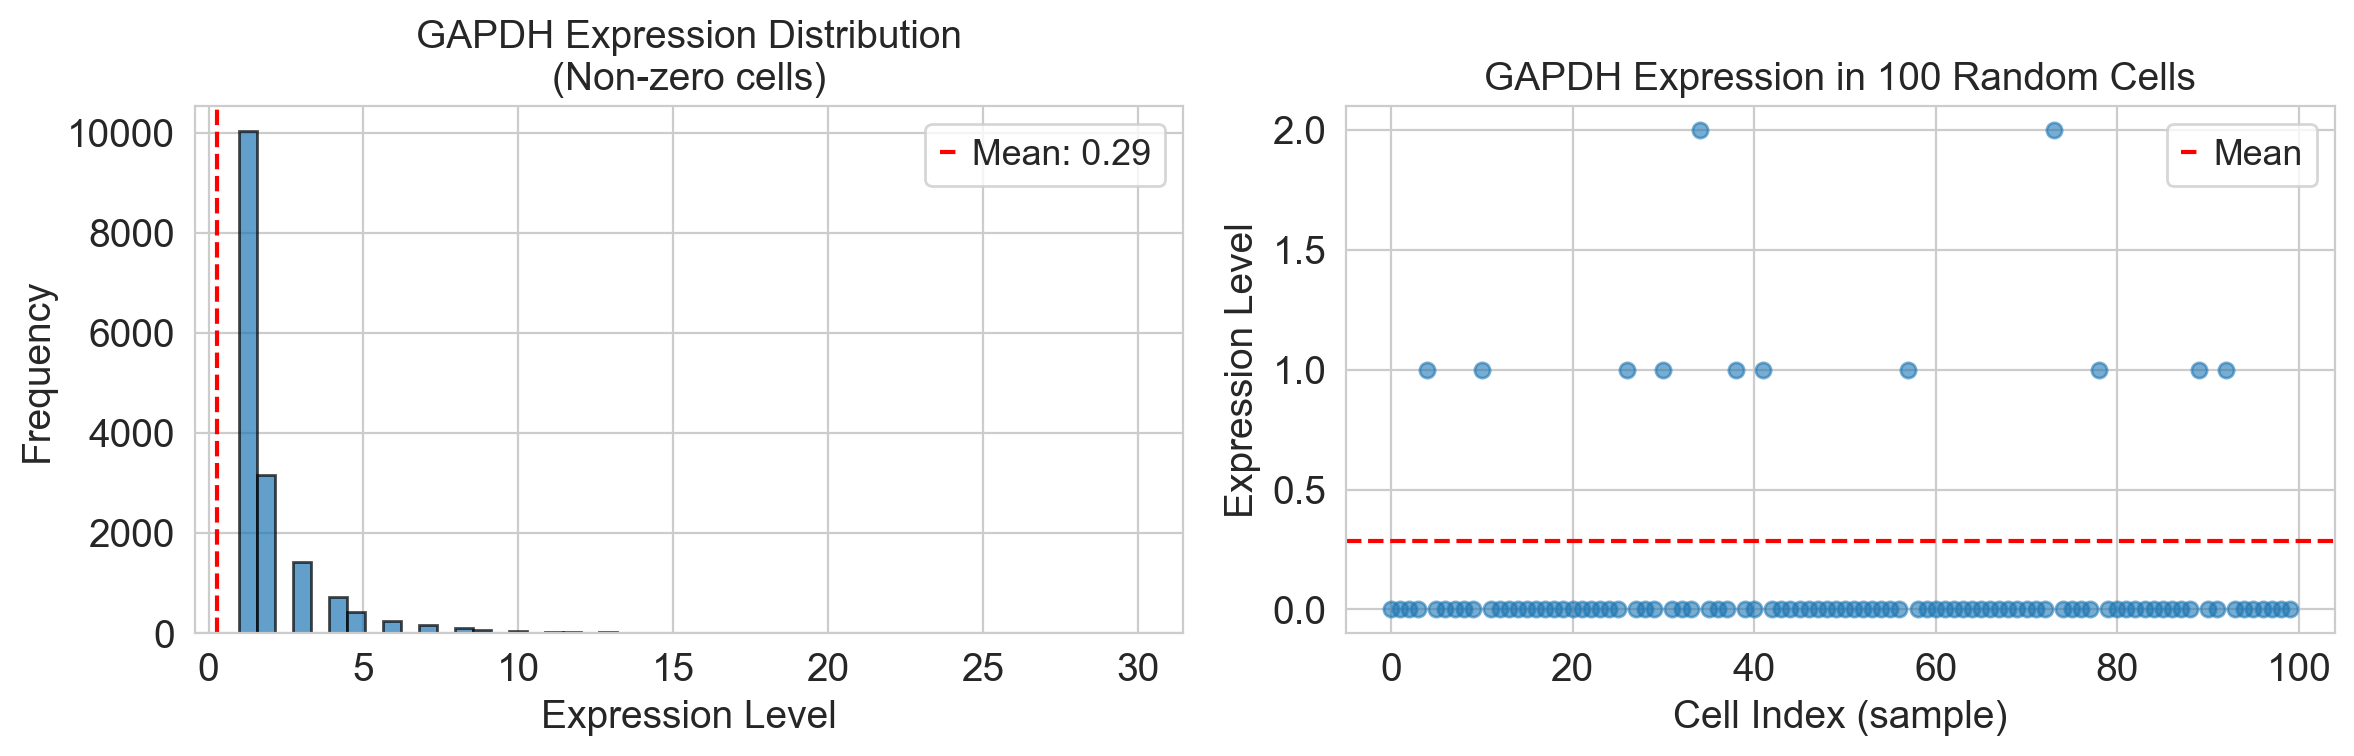


Perturbation Summary:
    gene                     type  n_cells  mean_before  mean_after  \
0  GAPDH  knock-down (factor=0.2)   112014     2.566001      0.5132   

   fold_change  
0          0.2  


In [15]:
# Create perturber and apply knock-down
perturber_kd = GenePerturber(adata, copy=True)
perturber_kd.knock_down(test_gene, factor=0.2)  # 80% reduction

# Visualize
perturber_kd.visualize_perturbation(test_gene)

# Get summary
print("\nPerturbation Summary:")
print(perturber_kd.get_perturbation_summary())

### 3.2 Knock-Up Demonstration

Applied knock-up (factor=4.0) to GAPDH in 112014 cells
  Mean expression: 2.566 → 10.264


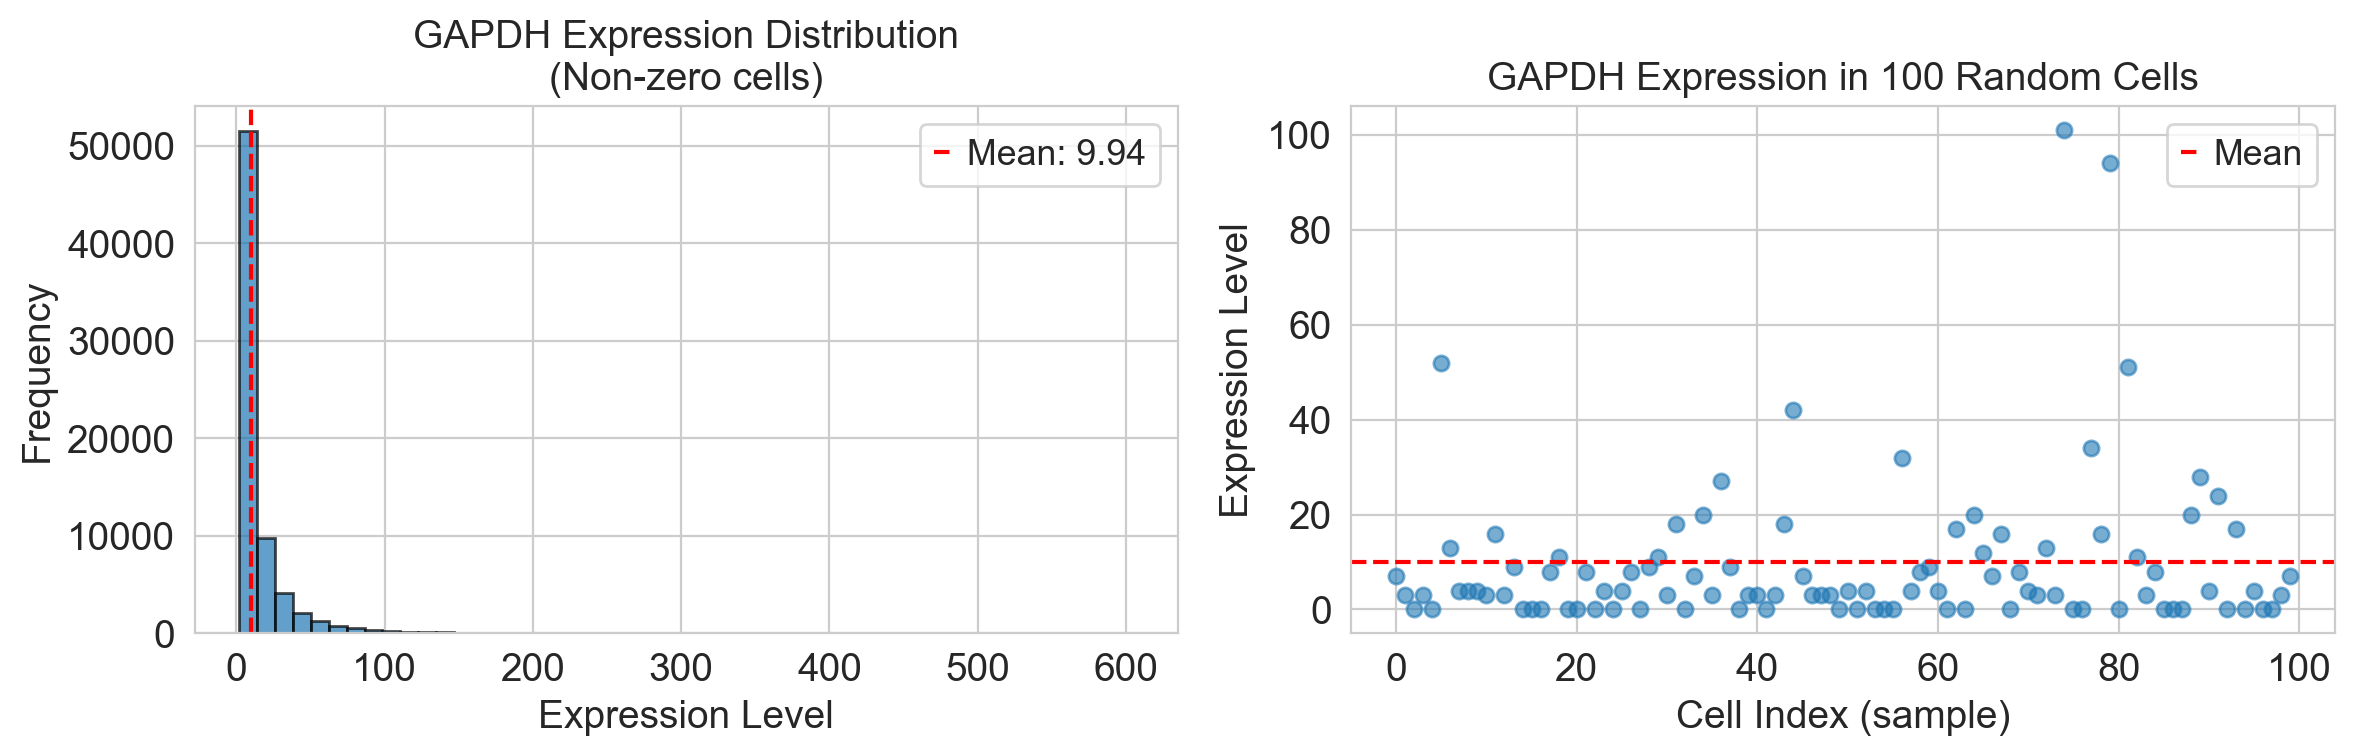


Perturbation Summary:
    gene                   type  n_cells  mean_before  mean_after  fold_change
0  GAPDH  knock-up (factor=4.0)   112014     2.566001    10.26439     4.000151


In [16]:
# Create perturber and apply knock-up
perturber_ku = GenePerturber(adata, copy=True)
perturber_ku.knock_up(test_gene, factor=4.0, add_noise=True)  # 4x increase with noise

# Visualize
perturber_ku.visualize_perturbation(test_gene)

# Get summary
print("\nPerturbation Summary:")
print(perturber_ku.get_perturbation_summary())

## 4. Demonstration: Multiple Gene Perturbations

Show scalability by perturbing multiple genes simultaneously.

In [17]:
# Select multiple test genes
gene_expr = adata.X.sum(axis=0).A1 if hasattr(adata.X, 'toarray') else adata.X.sum(axis=0)
top_genes = adata.var_names[np.argsort(gene_expr)[-20:]].tolist()  # Top 20 expressed genes
test_genes = top_genes[:5]  # Use 5 genes for demonstration

print(f"Testing workflow with {len(test_genes)} genes:")
for gene in test_genes:
    print(f"  - {gene}")

Testing workflow with 5 genes:
  - MT-CO2
  - DPP10
  - NRXN3
  - LSAMP
  - NRXN1


In [18]:
# Apply multiple perturbations
perturber_multi = GenePerturber(adata, copy=True)

# Knock down first 3 genes
perturber_multi.knock_down(test_genes[:3], factor=0.1)

# Knock up last 2 genes
perturber_multi.knock_up(test_genes[3:], factor=5.0)

# Display summary
summary_df = perturber_multi.get_perturbation_summary()
print("\n=== Multi-Gene Perturbation Summary ===")
print(summary_df.to_string())

Applied knock-down (factor=0.1) to MT-CO2 in 112014 cells
  Mean expression: 36.390 → 3.639
Applied knock-down (factor=0.1) to DPP10 in 112014 cells
  Mean expression: 38.618 → 3.862
Applied knock-down (factor=0.1) to NRXN3 in 112014 cells
  Mean expression: 38.911 → 3.891
Applied knock-up (factor=5.0) to LSAMP in 112014 cells
  Mean expression: 39.676 → 198.464
Applied knock-up (factor=5.0) to NRXN1 in 112014 cells
  Mean expression: 39.724 → 198.718

=== Multi-Gene Perturbation Summary ===
     gene                     type  n_cells  mean_before  mean_after  fold_change
0  MT-CO2  knock-down (factor=0.1)   112014    36.390067    3.639007     0.100000
1   DPP10  knock-down (factor=0.1)   112014    38.617798    3.861780     0.100000
2   NRXN3  knock-down (factor=0.1)   112014    38.910592    3.891059     0.100000
3   LSAMP    knock-up (factor=5.0)   112014    39.675710  198.464483     5.002166
4   NRXN1    knock-up (factor=5.0)   112014    39.723731  198.717810     5.002496


## 5. Demonstration: Cell-Type Specific Perturbations

Show how to apply perturbations to specific cell populations.

In [19]:
# Select a specific cell type
print("Available cell types:")
print(adata.obs['CellType'].value_counts().head(10))

# Choose the most abundant cell type
target_celltype = adata.obs['CellType'].value_counts().index[0]
cell_mask = adata.obs['CellType'] == target_celltype
cell_indices = np.where(cell_mask)[0]

print(f"\nTargeting {target_celltype}: {len(cell_indices)} cells")

Available cell types:
CellType
Oligo     19043
Astro     13178
L2_L3     11871
OPC        9416
L3_L5      9331
L4_L6      7512
L5_L6      6608
5HT3aR     6034
PV         5595
L6         4848
Name: count, dtype: int64

Targeting Oligo: 19043 cells


In [20]:
# Apply cell-type specific perturbation
perturber_celltype = GenePerturber(adata, copy=True)
perturber_celltype.knock_down(test_genes[0], 
                               factor=0.05, 
                               cell_indices=cell_indices)

print("\nCell-type specific perturbation summary:")
print(perturber_celltype.get_perturbation_summary())

Applied knock-down (factor=0.05) to MT-CO2 in 19043 cells
  Mean expression: 4.148 → 0.207

Cell-type specific perturbation summary:
     gene                      type  n_cells  mean_before  mean_after  \
0  MT-CO2  knock-down (factor=0.05)    19043     4.148086    0.207404   

   fold_change  
0         0.05  


## 6. Validation: Before vs After Comparison

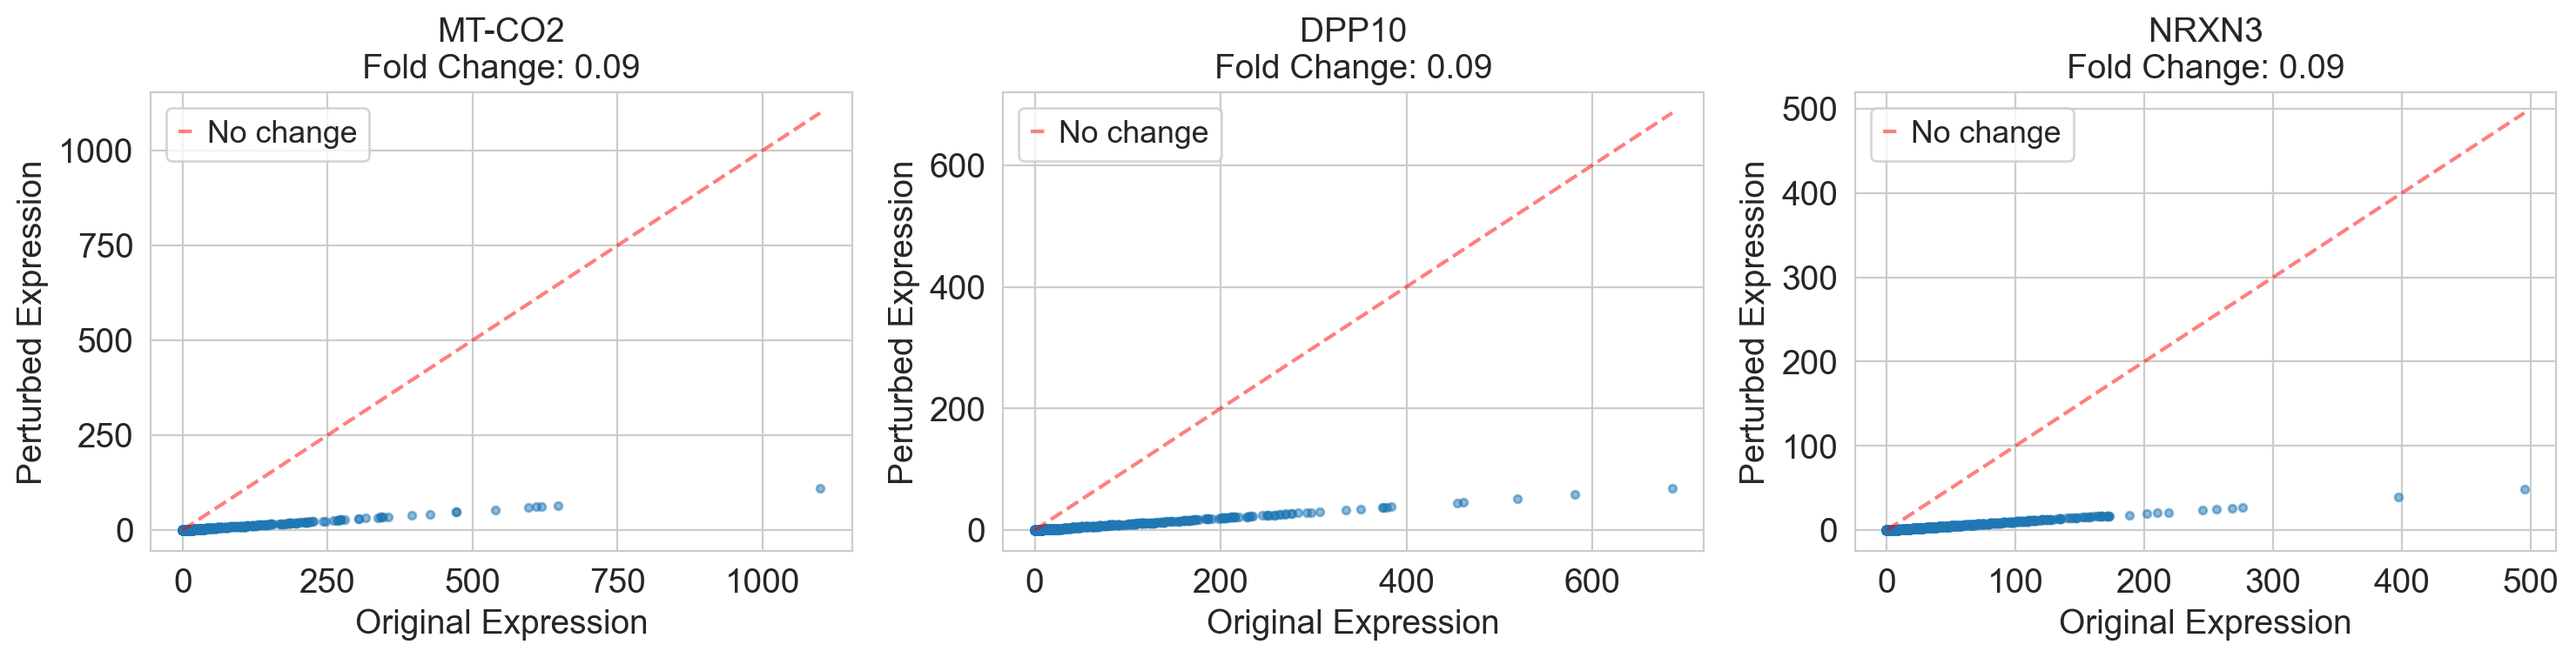

In [21]:
def compare_perturbations(original_adata, perturbed_adata, genes, n_cells=1000):
    """
    Compare original and perturbed expression for multiple genes.
    """
    n_genes = len(genes)
    fig, axes = plt.subplots(1, n_genes, figsize=(5*n_genes, 4))
    
    if n_genes == 1:
        axes = [axes]
    
    # Sample cells for visualization
    sample_idx = np.random.choice(original_adata.n_obs, 
                                  min(n_cells, original_adata.n_obs), 
                                  replace=False)
    
    for idx, gene in enumerate(genes):
        gene_idx = original_adata.var_names.get_loc(gene)
        
        # Get expression values
        orig_expr = original_adata.X[sample_idx, gene_idx].toarray().flatten() \
                   if hasattr(original_adata.X, 'toarray') else \
                   original_adata.X[sample_idx, gene_idx].flatten()
        
        pert_expr = perturbed_adata.X[sample_idx, gene_idx].toarray().flatten() \
                   if hasattr(perturbed_adata.X, 'toarray') else \
                   perturbed_adata.X[sample_idx, gene_idx].flatten()
        
        # Plot
        axes[idx].scatter(orig_expr, pert_expr, alpha=0.5, s=10)
        
        # Add diagonal line
        max_val = max(orig_expr.max(), pert_expr.max())
        axes[idx].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='No change')
        
        axes[idx].set_xlabel('Original Expression')
        axes[idx].set_ylabel('Perturbed Expression')
        axes[idx].set_title(f'{gene}\nFold Change: {pert_expr.mean()/orig_expr.mean():.2f}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

# Compare multi-gene perturbations
compare_perturbations(adata, 
                     perturber_multi.get_perturbed_data(), 
                     test_genes[:3])

## 7. Quality Control Metrics

In [22]:
def calculate_qc_metrics(original_adata, perturbed_adata):
    """
    Calculate quality control metrics for perturbation.
    """
    metrics = {}
    
    # Total counts per cell
    orig_counts = original_adata.X.sum(axis=1).A1 if hasattr(original_adata.X, 'toarray') \
                  else original_adata.X.sum(axis=1)
    pert_counts = perturbed_adata.X.sum(axis=1).A1 if hasattr(perturbed_adata.X, 'toarray') \
                  else perturbed_adata.X.sum(axis=1)
    
    metrics['mean_total_counts_change'] = (pert_counts.mean() - orig_counts.mean()) / orig_counts.mean()
    
    # Number of expressed genes per cell
    orig_n_genes = (original_adata.X > 0).sum(axis=1).A1 if hasattr(original_adata.X, 'toarray') \
                   else (original_adata.X > 0).sum(axis=1)
    pert_n_genes = (perturbed_adata.X > 0).sum(axis=1).A1 if hasattr(perturbed_adata.X, 'toarray') \
                   else (perturbed_adata.X > 0).sum(axis=1)
    
    metrics['mean_n_genes_change'] = (pert_n_genes.mean() - orig_n_genes.mean()) / orig_n_genes.mean()
    
    return metrics

# Calculate QC metrics
qc_metrics = calculate_qc_metrics(adata, perturber_multi.get_perturbed_data())

print("\n=== Quality Control Metrics ===")
print(f"Mean total counts change: {qc_metrics['mean_total_counts_change']*100:.2f}%")
print(f"Mean number of genes change: {qc_metrics['mean_n_genes_change']*100:.2f}%")
print("\nNote: Small changes in total counts indicate perturbations are localized to target genes.")


=== Quality Control Metrics ===
Mean total counts change: 1.81%
Mean number of genes change: -0.02%

Note: Small changes in total counts indicate perturbations are localized to target genes.


## 8. Save Perturbed Data (Example)

In [23]:
# Example: Save perturbed data for downstream analysis
# Uncomment to save
perturbed_adata = perturber_multi.get_perturbed_data()
perturbed_adata.write('outputs/hierarchical_files/perturbed_data_example.h5ad')
print("Perturbed data saved successfully.")

Perturbed data saved successfully.


## Summary

### Key Features of the Workflow:

1. **Flexible Perturbation Functions**
   - Knock-down: Reduces gene expression by a specified factor or complete knockout
   - Knock-up: Increases gene expression with optional biological noise
   
2. **Scalability**
   - Handles single or multiple genes
   - Supports cell-type specific perturbations
   - Efficient for large datasets (100K+ cells)
   
3. **Biological Realism**
   - Maintains non-negative expression values
   - Optional noise addition for knock-up experiments
   - Preserves data structure and metadata
   
4. **Quality Control**
   - Gene validation
   - Perturbation logging
   - Before/after comparison tools
   - QC metrics calculation
   
5. **Reproducibility**
   - Copy-on-write to preserve original data
   - Complete perturbation logging
   - Deterministic operations (when noise is disabled)

### Next Steps:
- Apply this workflow to ALS-specific genes (Task 2)
- Generate embeddings using GeneFormer
- Analyze perturbation effects in embedding space (Task 3)